<a href="https://colab.research.google.com/github/Aynahd/VeriAssist/blob/main/drugs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('drug200.csv')
print(df)

     Age Sex      BP Cholesterol  Na_to_K   Drug
0     23   F    HIGH        HIGH   25.355  DrugY
1     47   M     LOW        HIGH   13.093  drugC
2     47   M     LOW        HIGH   10.114  drugC
3     28   F  NORMAL        HIGH    7.798  drugX
4     61   F     LOW        HIGH   18.043  DrugY
..   ...  ..     ...         ...      ...    ...
195   56   F     LOW        HIGH   11.567  drugC
196   16   M     LOW        HIGH   12.006  drugC
197   52   M  NORMAL        HIGH    9.894  drugX
198   23   M  NORMAL      NORMAL   14.020  drugX
199   40   F     LOW      NORMAL   11.349  drugX

[200 rows x 6 columns]


Encode categorical variable : convert to numeric format for computation

In [5]:
def encode_column(column):
    unique_values = column.unique()
    mapping = {value: idx for idx, value in enumerate(unique_values)}
    return column.map(mapping), mapping

df['Sex'], sex_mapping = encode_column(df['Sex'])
df['BP'], bp_mapping = encode_column(df['BP'])
df['Cholesterol'], cholesterol_mapping = encode_column(df['Cholesterol'])
df['Drug'], drug_mapping = encode_column(df['Drug'])

Normalize : min max scaling

In [6]:
def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

df['Age'] = normalize_column(df['Age'])
df['Na_to_K'] = normalize_column(df['Na_to_K'])

In [7]:
X = torch.tensor(df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values, dtype=torch.float32)
y = torch.tensor(df['Drug'].values, dtype=torch.long)

In [8]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
class DrugClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DrugClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [14]:
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(drug_mapping)

model = DrugClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [15]:
num_epochs = 100
for epoch in range(num_epochs):

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 1.1284
Epoch [20/100], Loss: 0.8514
Epoch [30/100], Loss: 0.6493
Epoch [40/100], Loss: 0.4900
Epoch [50/100], Loss: 0.3631
Epoch [60/100], Loss: 0.2678
Epoch [70/100], Loss: 0.2035
Epoch [80/100], Loss: 0.1609
Epoch [90/100], Loss: 0.1321
Epoch [100/100], Loss: 0.1114


In [16]:
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_classes = torch.argmax(y_pred, axis=1)
    accuracy = (y_pred_classes == y_test).sum().item() / y_test.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 97.50%


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch

In [18]:

with torch.no_grad():
    outputs = model(X_test)
    predicted_classes = torch.argmax(outputs, dim=1)


In [19]:
y_true = y_test.cpu().numpy()
y_pred = predicted_classes.cpu().numpy()
cm = confusion_matrix(y_true, y_pred)

print(cm)


[[19  0  0  0  1]
 [ 0  3  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0  2]]


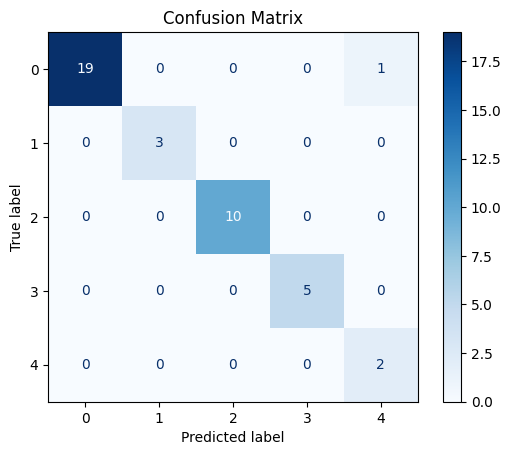

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [21]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

In [22]:
with torch.no_grad():
    outputs = model(X_test)
    predicted_classes = torch.argmax(outputs, dim=1)

y_true = y_test.cpu().numpy()
y_pred = predicted_classes.cpu().numpy()


In [25]:
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")


F1 Score: 0.98


In [24]:
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         5
           4       0.67      1.00      0.80         2

    accuracy                           0.97        40
   macro avg       0.93      0.99      0.95        40
weighted avg       0.98      0.97      0.98        40

